## Thermal Conduction
This examples shows how OpenPNM can be used to simulate thermal conduction on a generic grid of nodes. The result obtained from OpenPNM is compared to the analytical result. 

As usual, start by importing OpenPNM, and the SciPy library.

In [8]:
%matplotlib inline
import scipy as sp
import openpnm as op

## Generating the Network object

Next, 2D a **Network** is generated with dimensions of 10x50 elements. The lattice spacing is given by *Lc*. Boundaries are added all around the edges of **Network** object using the ``add_boundariy_pores`` method. 

In [9]:
divs = [10, 50]
Lc = 0.1  # cm
pn = op.network.Cubic(shape=divs, spacing=Lc)
pn.add_boundary_pores(['left', 'right', 'front', 'back'])

## Generating the Geometry object

After the **Network** is generated, a **Geometry** object is defined for the internal and the boundary pores.

In [10]:
geom = op.geometry.GenericGeometry(network=pn, pores=pn.Ps, throats=pn.Ts)

In this example we are using OpenPNM to calculate the temperature profile on a grid.  In this case each pore is a grid cell and they connect to each other on four sides. The throats are thus set to have the same dimensions as the pores, but a very short length so that the distance between the pores is very low.  Essentially the resistance is all coming from the pores.

In [11]:
geom['pore.area'] = Lc**2
geom['pore.diameter'] = Lc
geom['throat.length'] = 1e-25
geom['throat.area'] = Lc**2

There is one *gotcha* that must be considered with the boundary pores.  We genererally want these pores to offer no resistance, which means they should have zero length (ie. transport from the pore center to the entrance of the throat is negligible), so we will set these manually:

In [12]:
geom['pore.diameter'][pn.pores('*boundary')] = 1e-25

## Generating the Phases and Physics objects
Now a **Phase** object is defined along with a corresponding **Physics** object. On the **Phase** object, the thermal conductivity is set equal to 1.0 across the whole domain. The **Physics** object is then assigned a model for the thermal conduction simulation, which is the *series_resistors* model. This model will utilize the geometry properties we defined above to generate the correct conductances between cells.

In [13]:
# Create Phase object and associate with a Physics object
Cu = op.phases.GenericPhase(network=pn)
Cu['pore.thermal_conductivity'] = 1.0  # W/m.K
phys = op.physics.GenericPhysics(network=pn, phase=Cu, geometry=geom)
mod = op.models.physics.thermal_conductance.series_resistors
phys.add_model(propname='throat.thermal_conductance', model=mod)

## Generating the algorithm objects and running the simulation
The last step in the OpenPNM simulation involves the generation of a **Algorithm** object and running the simulation. 

In [14]:
# Setup Algorithm object
alg = op.algorithms.FourierConduction(network=pn)
alg.setup(phase=Cu)
inlets = pn.pores('back_boundary')
outlets = pn.pores(['front_boundary', 'left_boundary', 'right_boundary'])
T_in = 30*sp.sin(sp.pi*pn['pore.coords'][inlets, 1]/5)+50
alg.set_value_BC(values=T_in, pores=inlets)
alg.set_value_BC(values=50, pores=outlets)
alg.run()

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running ReactiveTransport
Tolerance not met: 2201128.0372058125
Solution converged: 0.0


This is the last step usually required in a OpenPNM simulation. The algorithm was run, and now the simulation data obtained can be analyzed. For illustrative purposes, the results obtained using OpenPNM shall be compared to an analytical solution of the problem in the following.

First let's rehape the 'pore.temperature' array into the shape of the network while also extracting only the internal pores to avoid showing the boundaries.

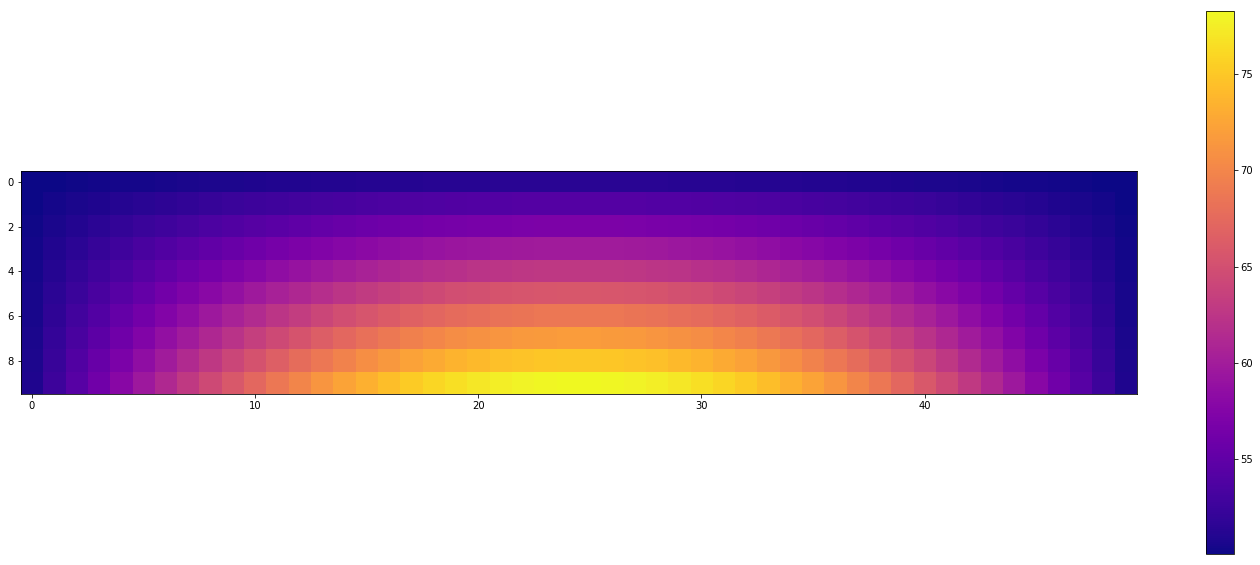

In [15]:
import matplotlib.pyplot as plt
sim = alg['pore.temperature'][pn.pores('internal')]
temp_map = sp.reshape(a=sim, newshape=divs)
plt.subplots(1, 1, figsize=[25, 10])
plt.imshow(temp_map, cmap=plt.cm.plasma)
plt.colorbar()

The analytical solution is computed in *Python* as well, and the result is the same shape as the network (including the boundary pores). 

In [16]:
# Calculate analytical solution over the same domain spacing
X = pn['pore.coords'][:, 0]
Y = pn['pore.coords'][:, 1]
soln = 30*sp.sinh(sp.pi*X/5)/sp.sinh(sp.pi/5)*sp.sin(sp.pi*Y/5) + 50
soln = soln[pn.pores('internal')]
soln = sp.reshape(soln, (divs[0], divs[1]))

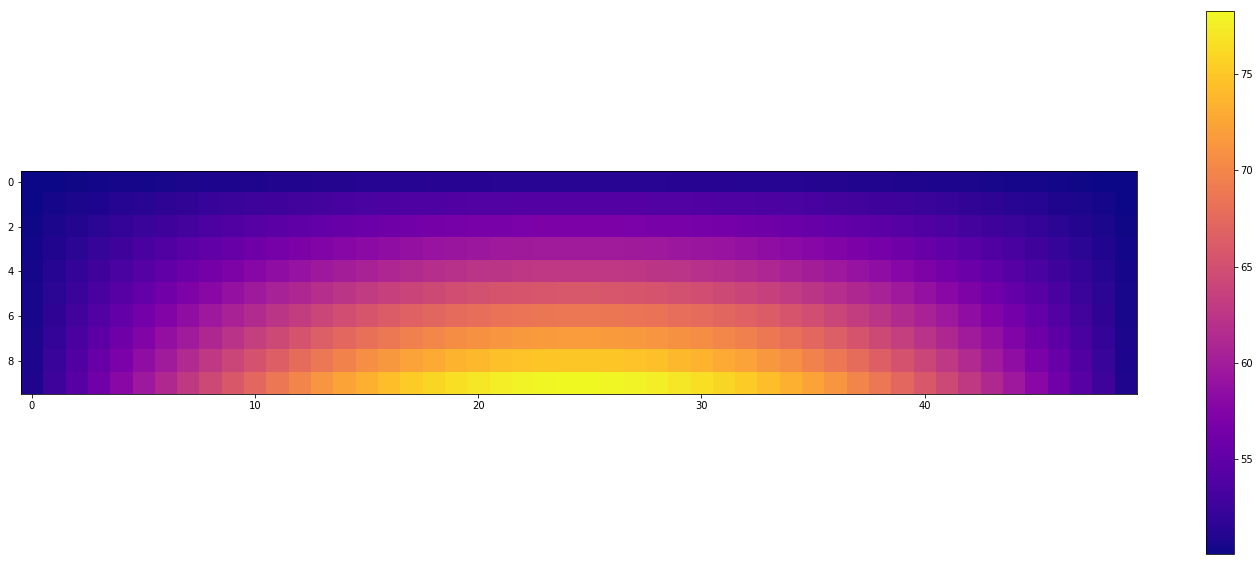

In [17]:
plt.subplots(1, 1, figsize=(25, 10))
plt.imshow(soln, cmap=plt.cm.plasma)
plt.colorbar()

Both the analytical solution and OpenPNM simulation can be subtracted from each other to yield the difference in both values.

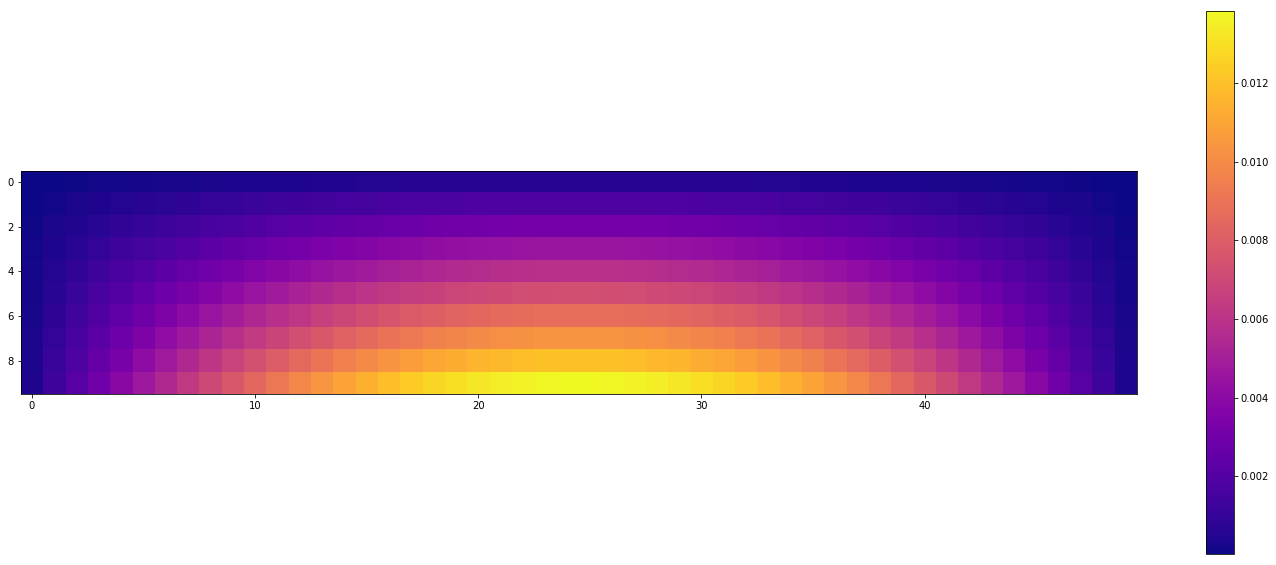

In [18]:
diff = soln - temp_map
plt.subplots(1, 1, figsize=(25, 10))
plt.imshow(diff, cmap=plt.cm.plasma)
plt.colorbar()

In [19]:
print(diff.min(), diff.max())

1.9912515625719607e-05 0.013840915744978588


The maximum error is 0.01 degrees on a 50 degree profile, which is quite good and thus demonstrates that the OpenPNM finite difference approach is versatile despite being simple.